In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

Using TensorFlow backend.


In [2]:
model = VGG16(weights="imagenet")
img_path = "./data/soccer_ball.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [3]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

In [4]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [5]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [6]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
cv2.imshow("Original", img)
cv2.imshow("GradCam", superimposed_img)
cv2.waitKey()
cv2.destroyAllWindows()

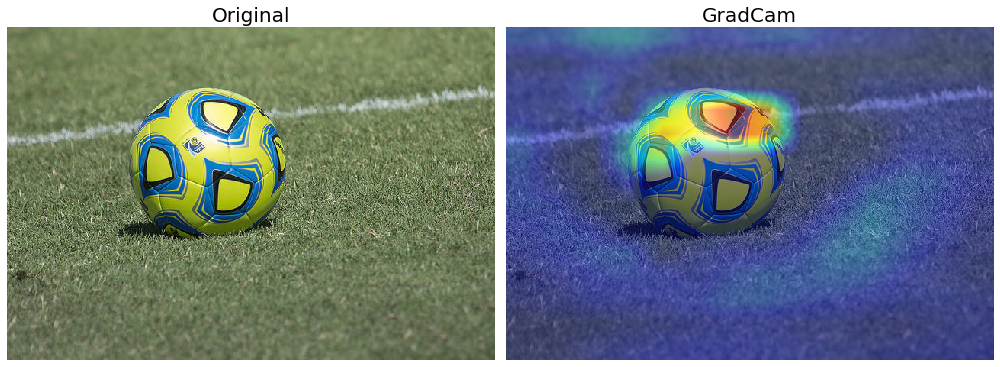

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

image1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.axis('off')
plt.title('Original', size=20)
plt.xticks([]), plt.yticks([])
plt.imshow(image1)

image2 = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
plt.subplot(122)
plt.axis('off')
plt.title('GradCam', size=20)
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image2)
plt.show()